In [1]:
import os

# Get the total number of CPUs
total_num_cpus = os.cpu_count()
fraction_to_use = 0.2
num_cpus_to_use = 1 #int(total_num_cpus * fraction_to_use)

# Set the environment variables
os.environ["OMP_NUM_THREADS"] = str(num_cpus_to_use)
os.environ["OPENBLAS_NUM_THREADS"] = str(num_cpus_to_use)
os.environ["MKL_NUM_THREADS"] = str(num_cpus_to_use)
os.environ["VECLIB_MAXIMUM_THREADS"] = str(num_cpus_to_use)
os.environ["NUMEXPR_NUM_THREADS"] = str(num_cpus_to_use)

#### Import Packages

In [2]:
import numpy as np
import tensorflow as tf
import keras as K

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from scipy.optimize import curve_fit

In [3]:
import multiprocessing
multiprocessing.cpu_count()

38

#### Package version

In [4]:
import sys
print(sys.version)
print(sys.version_info)
print("\n K:  ", K.__version__)
print("\n tf: ", tf.__version__)

print("\n")
!jupyter --version

3.10.13 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:15:57) [MSC v.1916 64 bit (AMD64)]
sys.version_info(major=3, minor=10, micro=13, releaselevel='final', serial=0)

 K:   2.10.0

 tf:  2.10.0


Selected Jupyter core packages...
IPython          : 8.20.0
ipykernel        : 6.28.0
ipywidgets       : 8.1.2
jupyter_client   : 8.6.0
jupyter_core     : 5.5.0
jupyter_server   : 2.10.0
jupyterlab       : 4.0.11
nbclient         : 0.8.0
nbconvert        : 7.10.0
nbformat         : 5.9.2
notebook         : 7.0.8
qtconsole        : 5.5.1
traitlets        : 5.7.1


#### Constants & setting Model

In [19]:
kT = 0.025
#~~~~~~~~~~~~~~~~~~~~~~
sigma_d = 1*kT
sigma_u = 7*kT
#~~~~~~~~~~~~~~~~~~~~~~
Eactv = 0.10
Eactv_d = Eactv - 0.02
Eactv_u = Eactv + 0.02
#~~~~~~~~~~~~~~~~~~~~~~
hopping_type_r = "Tunll"
# hopping_type_r = "Fors"

#hopping_type_e = "hh"
#hopping_type_e = "MA"
#hopping_type_e = "MAorigin"
hopping_type_e = "Plrn"
#~~~~~~~~~~~~~~~~~~~~~~
origin_energy_mean = 0.0
seen = 1 # 0~org_sigma=0  1~org_sigma=trap_sigma
#~~~~~~~~~~~~~~~~~~~~~~
Bc = 2.735
#~~~~~~~~~~~~~~~~~~~~~~
alpha = 0.2
alpha_d = alpha/5
alpha_u = 5*alpha
#~~~~~~~~~~~~~~~~~~~~~~
rho = 1.0
n_density = 1.37*(1e-6) # equivalent to 1/90^3

R_jump = 4.0
#V_sphere = (4./3)*(np.pi)*R_jump**3
V_cube = (2*R_jump)**3
N_trap_cube = int(V_cube*rho)
#n_excitions = n_density*N_trap_cube

#### Output file name 

In [20]:
data_otput_name = "Data_" + hopping_type_r + "_" + hopping_type_e
if hopping_type_e == "Plrn":
    data_otput_name += '0' + str(int(Eactv*100))
data_otput_name

'Data_Tunll_Plrn010'

#### Functions

In [8]:
def origin_energy_generation(m, org_mean, org_sigma):
    origin_energy = np.random.normal(org_mean, org_sigma, m)
    origin_energy = np.reshape(origin_energy, [m,1])
    return origin_energy
    

def trap_energy_generation(m, trap_mean, trap_sigma_d, trap_sigma_u):
    trap_energy = np.zeros([m, N_trap_cube])
    sigma_range = np.zeros(m)
    for i in range(m):
        sigma_range[i] = np.random.random()*(trap_sigma_u - trap_sigma_d) + trap_sigma_d
        trap_energy[i,:] = np.random.normal(trap_mean, sigma_range[i], N_trap_cube)
    return trap_energy, sigma_range


def trap_r_generation(m):
    trap_xyz = R_jump * (2*np.random.random([m, N_trap_cube, 3]) - 1)
    trap_r = np.linalg.norm(trap_xyz, axis=2)
    return trap_xyz, trap_r


def trap_alpha_generation(m, trap_alpha_d, trap_alpha_u):
    trap_alpha = np.random.random([m,1])*(trap_alpha_u - trap_alpha_d) + trap_alpha_d
    return trap_alpha


def trap_Eactv_generation(m, trap_Eactv_d, trap_Eactv_u):
    trap_Eactv = np.random.random([m,1])*(trap_Eactv_u - trap_Eactv_d) + trap_Eactv_d
    return trap_Eactv


def detailed_balance_transitio_rate(deltaij):
    if    hopping_type_e == "hh": A = 1/2
    elif  hopping_type_e == "MA": A = 0

    barrier_Energy =  (deltaij + (1-2*A)*np.fabs(deltaij)) / 2
    return barrier_Energy
    

def trap_frequency_generation(origin_energy, trap_energy, trap_r, trap_alpha, trap_Eactv):
    deltaij = trap_energy - origin_energy
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    if hopping_type_e == "MAorigin":
        nu_ij_e = np.sign(deltaij)* (1/(np.exp(deltaij/kT)-1))
    elif hopping_type_e == "Plrn":
        lambda_en = 4*trap_Eactv
        barrier_Energy = ((lambda_en + deltaij)**2)/(4*lambda_en)
        nu_ij_e =  np.exp(- barrier_Energy/kT)*np.sqrt(1/(lambda_en*kT))
    else:
        barrier_Energy = detailed_balance_transitio_rate(deltaij)
        nu_ij_e =  np.exp(- barrier_Energy/kT)
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    if hopping_type_r == "Tunll": 
        nu_ij_r = np.exp(-2*trap_r/trap_alpha)
    else:
        nu_ij_r = (1/trap_r**6)
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    trap_jump_freqency = nu_ij_r * nu_ij_e
    return trap_jump_freqency


def data_generation(origin_energy, trap_energy, trap_r, trap_alpha, trap_Eactv):
    m = origin_energy.shape[0]
    #~~~~~~~~~~~~~~~~~~
    trap_jump_freqency = trap_frequency_generation(origin_energy, trap_energy, trap_r, trap_alpha, trap_Eactv)
    jump_OMEGA = (np.cumsum(trap_jump_freqency, axis=1).T / np.sum(trap_jump_freqency, axis=1)).T
    coin = np.random.random([m,1])
    jump_to = np.where(jump_OMEGA < coin, 0, 1).argmax(axis=1)
    #~~~~~~~~~~~~~~~~~~
    X_train01 = origin_energy
    X_train02 = trap_energy
    X_train03 = trap_r/trap_alpha
    

    Y_train01 = np.zeros([m,2])
    Y_train01[:,0] = trap_energy[np.arange(m), jump_to]
    Y_train01[:,1] = np.random.random(m)

    Y_train02 = trap_energy[np.arange(m), jump_to].reshape([m, 1])
    Y_train02 = ((Y_train02 - origin_energy) > 0).astype(int)
    Y_train02 = tf.keras.utils.to_categorical(Y_train02, num_classes=2)
    
    Y_train03 = np.zeros([m,2])
    Y_train03[:,0] = trap_r[np.arange(m), jump_to]
    Y_train03[:,1] = np.random.random(m)
    
    return X_train01, X_train02, X_train03, Y_train01, Y_train02, Y_train03

#### Sample ekMC step

In [9]:
m = 1

trap_energy, sigma_range = trap_energy_generation(m, 0, sigma_d, sigma_u)
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
origin_energy_sigma = 1e-5
if seen: origin_energy_sigma = sigma_range
origin_energy = origin_energy_generation(m, origin_energy_mean, origin_energy_sigma)
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
trap_xyz, trap_r = trap_r_generation(m)
trap_alpha = trap_alpha_generation(m, alpha_d, alpha_u)
trap_Eactv = trap_Eactv_generation(m, Eactv_d, Eactv_u)

(X_train01, X_train02, X_train03, 
 Y_train01, Y_train02, Y_train03) = data_generation(origin_energy, trap_energy, trap_r, trap_alpha, trap_Eactv)


print(X_train01.shape) # origin_energy
print(X_train02.shape) # trap_energy
print(X_train03.shape) # trap_r

print(Y_train01.shape) # distination of energy
print(Y_train02.shape) # upward / downward jump
print(Y_train03.shape) # distination of jump distances

X_train01.mean(), X_train02.mean(), Y_train01[:,0].mean()

(1, 1)
(1, 512)
(1, 512)
(1, 2)
(1, 2)
(1, 2)


(0.04444594224684495, -0.003849269122984016, -0.10909188567314947)

#### Setting plot style

In [10]:
plt.rcdefaults()
plt.rcParams['text.usetex'] = True

%matplotlib inline
# The following %config line changes the inline figures to have a higher DPI.
# You can comment out (#) this line if you don't have a high-DPI (~220) display.
%config InlineBackend.figure_format = 'retina'

In [11]:
import scienceplots

plt.style.use(['science', 'no-latex'])
#plt.style.use(['science','ieee', 'no-latex'])

###### Sample plot

Text(2.1, 0.7, 'odd: $ \\mathit{\\alpha} \\alpha $')

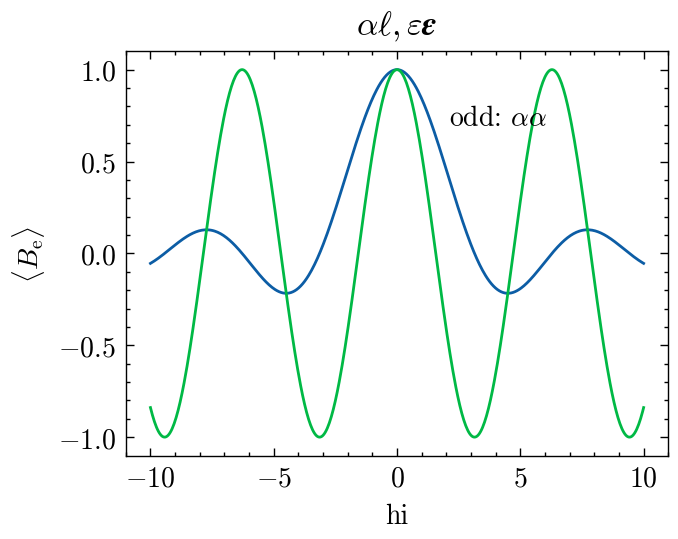

In [12]:
x = np.linspace(-10, 10, 500)
plt.plot(x, np.sin(x)/x)
plt.plot(x, np.cos(x))
plt.xlabel('hi')
plt.ylabel(r'$\langle \mathit{B}_{\mathrm{e}} \rangle$')
plt.title(r'$\alpha \ell , \varepsilon \mathbfit{\varepsilon}$')
plt.text(2.1, .7, r"odd: $ \mathit{\alpha} \alpha $")

#plt.savefig("fsrst.pdf")

#### An ekMC step

In [13]:
recursive_jump = False

N_samples = 100000   # ensemble

trap_mean = 0
trap_sigma_d = (1/0.3)*kT 
trap_sigma_u = (1/0.3)*kT

org_mean = 0
org_sigma = trap_sigma_d

trap_alpha_d = 0.1
trap_alpha_u = 0.1

trap_Eactv_d = Eactv
trap_Eactv_u = Eactv

if not(recursive_jump):
    origin_energy = origin_energy_generation(N_samples, org_mean, org_sigma)
else:
    origin_energy = Y_train01[:,[0]]
    
trap_energy, _ = trap_energy_generation(N_samples, trap_mean, trap_sigma_d, trap_sigma_u)
trap_xyz, trap_r = trap_r_generation(N_samples)
trap_alpha = trap_alpha_generation(N_samples, trap_alpha_d, trap_alpha_u)
trap_Eactv = trap_Eactv_generation(N_samples, trap_Eactv_d, trap_Eactv_u)
(X_train01, X_train02, X_train03, 
    Y_train01, Y_train02, Y_train03) = data_generation(origin_energy, trap_energy, trap_r, trap_alpha, trap_Eactv)

Y_train01.shape

(100000, 2)

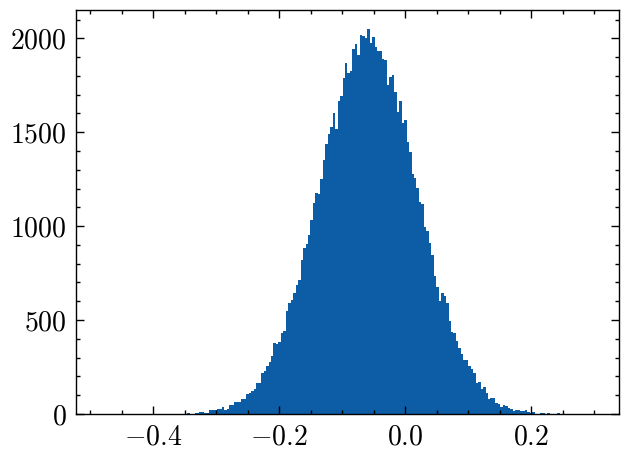

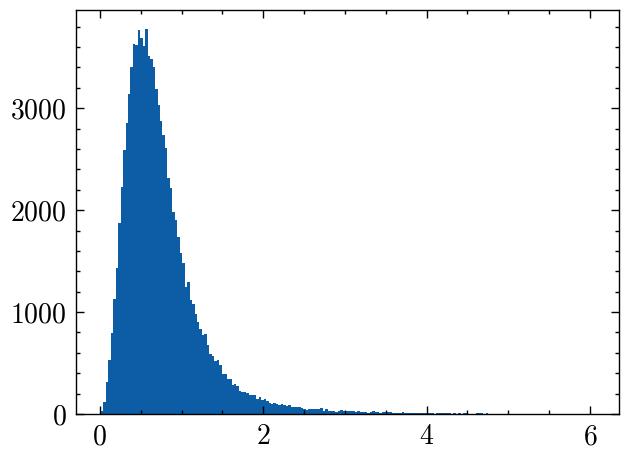

org = -0.060164671298404415
org_scaled = -0.7219760555808529


In [14]:
bins = 200
bins_e = 200
bins_r = 200

#~~~~~~~~~~~~~~~~~~~~ en
org_data = plt.hist(Y_train01[:,0], bins)
plt.show()

#~~~~~~~~~~~~~~~~~~~~ r
org_data_r = plt.hist(Y_train03[:,0], bins)
plt.show()

###########
org_E_peak = org_data[1][np.argmax(org_data[0])]

print("org =", org_E_peak)
print("org_scaled =", org_E_peak/trap_sigma_d)

[-0.06081216  0.07805372  0.97471006]


Text(0.5, 1.0, 'org -0.729746')

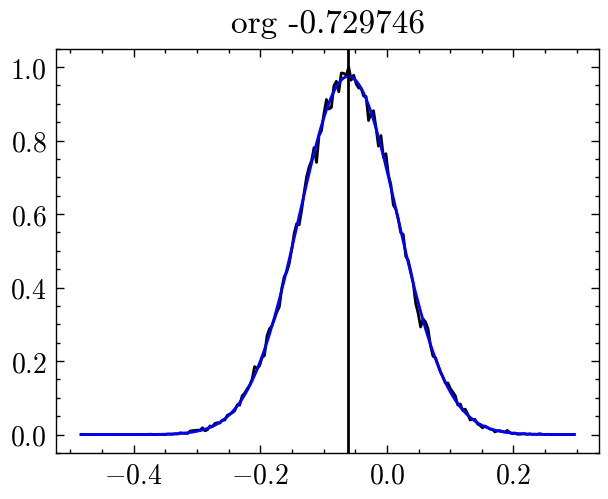

In [15]:

############################################
def f(x, fit_mean, fit_sigma, fit_weight):
    return fit_weight*np.exp(-(x-fit_mean)**2/(2*fit_sigma**2))


###########################################
x_org = org_data[1][:-1]
y_org = org_data[0]/np.max(org_data[0])

x_org_r = org_data_r[1][:-1]
y_org_r = org_data_r[0]/np.max(org_data_r[0])

paramaterOPT_org, covError_org= curve_fit(f, x_org, y_org, bounds=((-2, 0, 0), (2, 5, 2)))
print(paramaterOPT_org)

############################################
plt.plot(x_org, y_org, 'k')
plt.plot(x_org, f(x_org, *paramaterOPT_org), color = "b")
plt.axvline(x=paramaterOPT_org[0], color = 'k')
plt.title('org %f' %(paramaterOPT_org[0]/trap_sigma_d))


#### Iterative ekMC steps: approaching TE

In [ ]:
N_particles = 20000  # ensemble

bins_here = int(N_particles/100)

N_jumps = 12
N_mesh = 15

trap_Eactv_d = Eactv
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
sigma_list = np.array([1, 1.5, 2, 2.25, 2.5, 3, 3.25, 3.5, 4, 4.25, 4.5, 5, 5.25, 5.5, 6])*kT
alpha_list = np.array([1, 1.5, 2, 2.25, 2.5, 3, 3.25, 3.5, 4, 4.25, 4.5, 5, 5.25, 5.5, 6])*0.1

Nsigma = len(sigma_list)
Nalpha = len(alpha_list)
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~   
prd_e_peak_seq = np.zeros([Nsigma, Nalpha, 2, N_jumps])
prd_r_mean_seq = np.zeros([Nsigma, Nalpha, 2, N_jumps])
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~   

fig = plt.figure(figsize=(1,1))
ax = fig.add_subplot(1, 1, 1)

for j in range(Nsigma):
    for k in range(Nalpha):
        for n in range(2):
            #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            if_exp = 0
            trap_mean = 0
            trap_sigma_d = sigma_list[j]
            #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            trap_alpha_d = alpha_list[k]
            #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            org_sigma = 1e-5
            if n: org_mean = 3*trap_sigma_d
            else: org_mean = -trap_sigma_d**2/kT
            #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            print(j, k, n, round(trap_sigma_d, 3), round(trap_alpha_d, 3), round(org_mean, 3))
            #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            start_jump = 1
            for i in range(N_jumps):
                if start_jump == 1:
                    origin_energy = origin_energy_generation(N_particles, org_mean, org_sigma)
                else:
                    origin_energy = Y_train01[:,[0]]
                #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~    
                trap_energy, _ = trap_energy_generation(N_particles, trap_mean, trap_sigma_d, trap_sigma_d)
                trap_xyz, trap_r = trap_r_generation(N_particles)
                trap_alpha = trap_alpha_generation(N_particles, trap_alpha_d, trap_alpha_d)
                trap_Eactv = trap_Eactv_generation(N_particles, trap_Eactv_d, trap_Eactv_d)
                
                (X_train01, X_train02, X_train03, 
                 Y_train01, Y_train02, Y_train03) = data_generation(origin_energy, trap_energy, trap_r, trap_alpha, trap_Eactv)
                #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~      
                prd_data = ax.hist(Y_train01[:,0], bins_here)
                prd_data_r = ax.hist(Y_train03[:,0], bins_here)
                
                x_prd = prd_data[1][:-1]
                y_prd = prd_data[0]/np.max(prd_data[0])
                paramaterOPT_prd, covError_prd = curve_fit(f, x_prd, y_prd, bounds=((-3, 0, 0), (3, 5, 2)))
                
                prd_e_peak_seq[j, k, n, i] = paramaterOPT_prd[0]
                prd_r_mean_seq[j, k, n, i] = np.sum(prd_data_r[1][:-1]*prd_data_r[0][:])/(np.sum(prd_data_r[0]))
                #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~    
                        
                start_jump += 1
                
sys.getsizeof(prd_e_peak_seq)

#### running an example diffusion

In [ ]:
N_particles = 100000 # ensemble

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
if_exp = 0
trap_mean = 0
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
sigma_list = np.array([1, 1.5, 2, 2.25, 2.5, 3, 3.25, 3.5, 4, 4.25, 4.5, 5, 5.25, 5.5, 6])*kT
alpha_list = np.array([1, 1.5, 2, 2.25, 2.5, 3, 3.25, 3.5, 4, 4.25, 4.5, 5, 5.25, 5.5, 6])*0.1
step_list = np.array([100, 200, 300])

trap_Eactv_d = Eactv
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
N_mesh = len(sigma_list)
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
D = np.zeros([3, N_mesh, N_mesh])

for s in range(3):
    N_diff_step = step_list[s]
    for k in range(N_mesh):#alpha
        for j in range(N_mesh): #sigma
            print(s, k, j)
            
            positionx = np.zeros([N_particles,1])
            positiony = np.zeros([N_particles,1])
            positionz = np.zeros([N_particles,1])
            t_sim = np.zeros([N_particles,1])
            
            trap_sigma_d = sigma_list[j]
            trap_alpha_d = alpha_list[k]
            
            org_mean = 0
            org_sigma = sigma_list[j]
            
            start_jump = 1
            for i in range(N_diff_step):
                if start_jump == 1:
                    origin_energy = origin_energy_generation(N_particles, org_mean, org_sigma)
                    trap_alpha = trap_alpha_generation(N_particles, trap_alpha_d, trap_alpha_d)
                    trap_Eactv = trap_Eactv_generation(N_particles, trap_Eactv_d, trap_Eactv_d)
                else:
                    origin_energy = Y_train01[:,[0]]
                #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
                trap_energy, _ = trap_energy_generation(N_particles, trap_mean, trap_sigma_d, trap_sigma_d)
                trap_xyz, trap_r = trap_r_generation(N_particles)
                trap_jump_freqency = trap_frequency_generation(origin_energy, trap_energy, trap_r, trap_alpha, trap_Eactv)
                nu_tot = np.sum(trap_jump_freqency, axis=1).reshape([N_particles, 1])
                #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~                                               
                (X_train01, X_train02, X_train03, 
                 Y_train01, Y_train02, Y_train03) = data_generation(origin_energy, trap_energy, trap_r, trap_alpha, trap_Eactv)
                #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
                if i >= 20:
                    t_sim += -(1/(5.5*1e5*nu_tot))*np.log(np.random.random([N_particles,1]))                
                    # ~~~~~~~~~~~
                    theta = np.arccos((1-2*np.random.random([N_particles,1])))
                    phi = (2*np.pi)*np.random.random([N_particles,1])
                    # ~~~~~~~~~~~
                    positionx += Y_train03[:,[0]]*np.sin(theta)*np.cos(phi)
                    positiony += Y_train03[:,[0]]*np.sin(theta)*np.sin(phi)
                    positionz += Y_train03[:,[0]]*np.cos(theta)
                #~~~~~~~~~~~~~~~~~~
                start_jump += 1
        
            r2 = positionx**2 + positiony**2 + positionz**2
            r2_ave = np.mean(r2)
            t_sim_ave = np.mean(t_sim)
            D[s,k,j] = r2_ave/t_sim_ave

print(D)

#### Saving (loading) data

In [21]:
output_file = data_otput_name

# np.savez(output_file,  sigma_list = sigma_list,
#                        alpha_list = alpha_list,
#                        prd_e_peak_seq = prd_e_peak_seq,                
#                        prd_r_mean_seq = prd_r_mean_seq,
#                     #    D = D,
#                        )

data_load = np.load( data_otput_name + '.npz')
sigma_list = data_load['sigma_list']
alpha_list = data_load['alpha_list']
prd_e_peak_seq = data_load['prd_e_peak_seq']
prd_r_mean_seq = data_load['prd_r_mean_seq']
D = data_load['D']

#### $\log(D)$ vs $(\sigma/kT)^2$

[0.26653068 7.47262741]
[0.27881252 7.57900264]


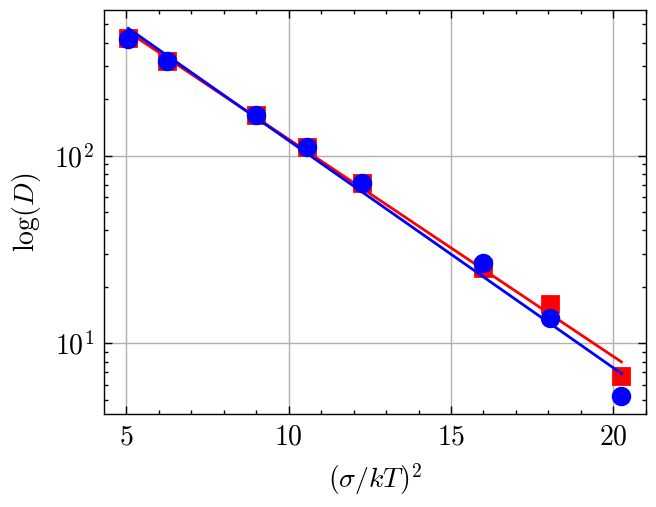

In [22]:
#sigma_list = np.array([1, 1.5, 2, 2.25, 2.5, 3, 3.25, 3.5, 4, 4.25, 4.5, 5, 5.25, 5.5, 6])*kT
#alpha_list = np.array([1, 1.5, 2, 2.25, 2.5, 3, 3.25, 3.5, 4, 4.25, 4.5, 5, 5.25, 5.5, 6])*0.1
#step_list = np.array([100, 200, 300, 400])

N_mesh = 15
x = np.array(sigma_list)/kT

#fit
f1 = 3
f2 = 11
# plot
p1 = 3
p2 = 11
############################################
def mu_VRH(x, C, b):
    return b - C*(x)**2 

#~~~~~~~ VS SIGMA ~~~~~~~~~~~~
# plot
s = 0
k = 5
OPT_C, covError = curve_fit(mu_VRH, x[f1:f2], np.log(D[s,k,f1:f2]))
plt.plot((x**2)[p1:p2], D[s,k, p1:p2], 'sr')
plt.plot((x**2)[p1:p2], np.exp(mu_VRH(x, *OPT_C)[p1:p2]), 'r-')
print(OPT_C)

s = 1
k = 5
OPT_C, covError = curve_fit(mu_VRH, x[f1:f2], np.log(D[s,k,f1:f2]))
plt.plot((x**2)[p1:p2], D[s,k, p1:p2] , 'ob')
plt.plot((x**2)[p1:p2], np.exp(mu_VRH(x, *OPT_C)[p1:p2]) , 'b-')
print(OPT_C)

plt.yscale('log')
#ax.set_xlim([4, 16])
plt.xlabel(r'$(\sigma/kT)^2$')
plt.ylabel(r'$\log(D)$')
plt.grid()

#### convergence plot for $E_{\text{tr}}$

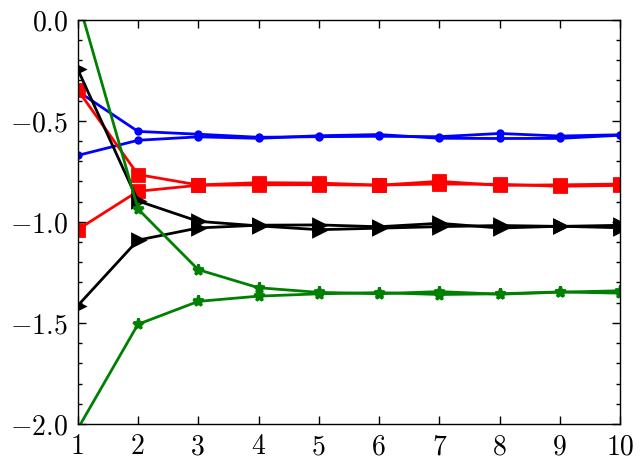

In [23]:
#sigma_list = np.array([1, 1.5, 2, 2.25, 2.5, 3, 3.25, 3.5, 4, 4.25, 4.5, 5, 5.25, 5.5, 6])*kT
#alpha_list = np.array([1, 1.5, 2, 2.25, 2.5, 3, 3.25, 3.5, 4, 4.25, 4.5, 5, 5.25, 5.5, 6])*0.1

alphaK = 5
sj = [2, 5, 8, 14]
mrk = ['.-b', 's-r', '>-k', '*-g']

for j, mr in zip(sj, mrk):
    plt.plot(prd_e_peak_seq[j, alphaK, 0, :]/sigma_list[j], mr, markersize=4)
    plt.plot(prd_e_peak_seq[j, alphaK, 1, :]/sigma_list[j], mr, markersize=4)

plt.xlim([0, 9])
plt.ylim([-2.0, 0.0])
#plt.xlabel(r'$\text{number of hoppings}$', fontsize=12)
#plt.ylabel(r"$\varepsilon_{\text{pk}}'/\sigma$", fontsize=12)

plt.gca().set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
plt.gca().set_xticklabels([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
plt.gca().tick_params(axis='x', which='minor', bottom=False, top=False)

#plt.gca().yaxis.tick_right() 
#plt.gca().yaxis.tick_left() 
# plt.savefig("fig04b.svg", transparent=True)

Text(0, 0.5, '$E_{\\text{tr}}/\\sigma$')

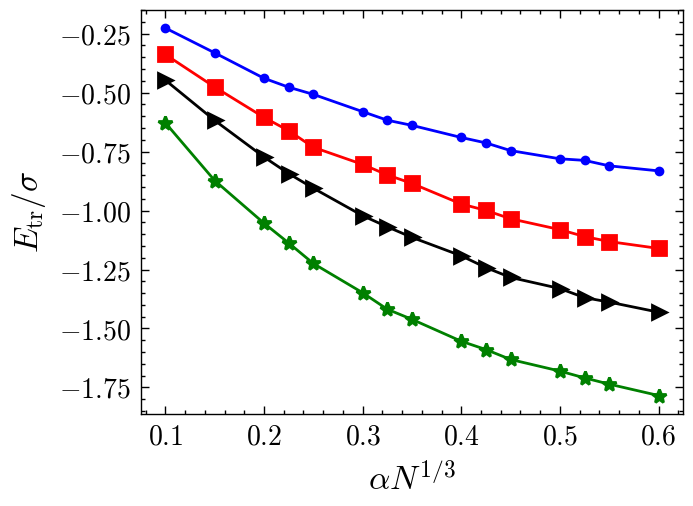

In [27]:
# e_tr vs alpha

sj = [2, 5, 8, 14]
mrk = ['.-b', 's-r', '>-k', '*-g']

for j, mr in zip(sj, mrk):
    plt.plot(alpha_list, prd_e_peak_seq[j, :, 0, -1]/sigma_list[j], mr, markersize=5)


#plt.ylim([-2.0, 0.0])
#plt.xlim([0.09, 0.61])
plt.xlabel(r'$\alpha N^{1/3}$', fontsize=12)
plt.ylabel(r"$E_{\text{tr}}/\sigma$", fontsize=12)

#plt.savefig("fig08a.svg", transparent=True)

#### convergence plot $r_{mean}$

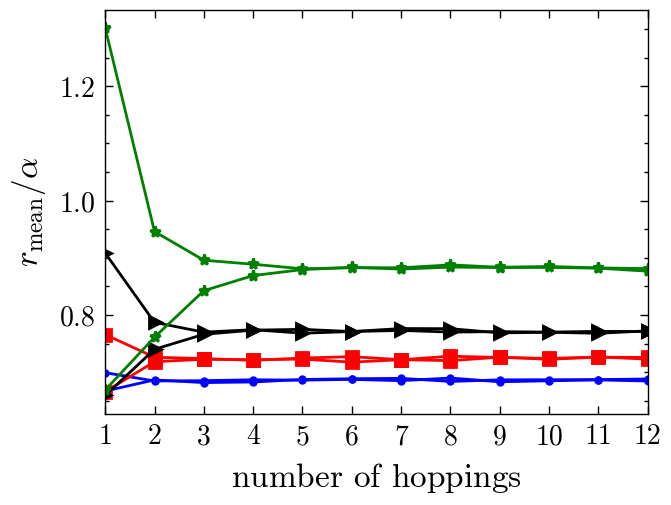

In [29]:
#sigma_list = np.array([1, 1.5, 2, 2.25, 2.5, 3, 3.25, 3.5, 4, 4.25, 4.5, 5, 5.25, 5.5, 6])*kT
#alpha_list = np.array([1, 1.5, 2, 2.25, 2.5, 3, 3.25, 3.5, 4, 4.25, 4.5, 5, 5.25, 5.5, 6])*0.1

alphaK = 5 #0
sj = [2, 5, 8, 14]
mrk = ['.-b', 's-r', '>-k', '*-g']

for j, mr in zip(sj, mrk):
    # plt.plot(prd_r_mean_seq[j, alphaK, 0, :]/alpha_list[alphaK], mr, markersize=4)
    # plt.plot(prd_r_mean_seq[j, alphaK, 1, :]/alpha_list[alphaK], mr, markersize=4)
    plt.plot(prd_r_mean_seq[j, alphaK, 0, :], mr, markersize=4)
    plt.plot(prd_r_mean_seq[j, alphaK, 1, :], mr, markersize=4)

plt.xlim([0, 9])
# plt.ylim([1.5, 4.0])
plt.xlabel(r'$\text{number of hoppings}$', fontsize=12)
plt.ylabel(r"$r_{\text{mean}}/\alpha$", fontsize=12)

plt.gca().set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
plt.gca().set_xticklabels([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
plt.gca().tick_params(axis='x', which='minor', bottom=False, top=False)


#plt.savefig("fig07a.svg", transparent=True)